# embeddings

In [1]:
import tensorflow as tf
import numpy as np
import os
import pickle as pkl
from pathlib import Path
from PIL import Image
import json

tf.config.run_functions_eagerly(True)

def setup_inception_v3():
    
    try:
        from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
        from tensorflow.keras.preprocessing import image as keras_image
        
        model = InceptionV3(
            weights='imagenet',
            include_top=False,
            pooling='avg',  # Global average pooling -> 2048 features
            input_shape=(299, 299, 3)
        )
        
        return model, preprocess_input, keras_image
        
    except Exception as e:
        return None, None, None

def extract_inception_features(image_path, model, preprocess_input, keras_image):
    
    try:
        img = keras_image.load_img(image_path, target_size=(299, 299))
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        img_array = preprocess_input(img_array)
        
        features = model.predict(img_array, verbose=0)
        
        return features.flatten()  # Shape: (2048,)
        
    except Exception as e:
        return None

def scan_dataset(dataset_path):
    """Scan dataset and create image list."""
    
    dataset_path = Path(dataset_path)
    image_list = []
    
    for category_dir in dataset_path.iterdir():
        if category_dir.is_dir():
            category_name = category_dir.name
            
            extensions = ['*.jpg', '*.jpeg', '*.png']
            category_count = 0
            
            for ext in extensions:
                for img_path in category_dir.glob(ext):
                    image_list.append({
                        'path': str(img_path),
                        'category': category_name,
                        'image_id': f"{category_name}_{img_path.stem}"
                    })
                    category_count += 1
    
    return image_list

def extract_all_features(dataset_path, output_path):
    
    # Setup InceptionV3
    model, preprocess_input, keras_image = setup_inception_v3()
    
    if model is None:
        return False
    
    # Scan dataset
    image_list = scan_dataset(dataset_path)
    
    if not image_list:
        return False
    
    # Test with first image
    test_image = image_list[0]
    test_features = extract_inception_features(
        test_image['path'], model, preprocess_input, keras_image
    )
    
    if test_features is None:
        return False
    
    # Extract features for all images
    print(f"Extracting features for {len(image_list)} images...")
    
    inception_features = {}
    processed = 0
    errors = 0
    
    for i, image_info in enumerate(image_list):
        image_path = image_info['path']
        image_id = image_info['image_id']
        category = image_info['category']
        
        if i % 20 == 0:
            print(f"Processing {i+1}/{len(image_list)}: {os.path.basename(image_path)}")
        
        # Extract features
        features = extract_inception_features(image_path, model, preprocess_input, keras_image)
        
        if features is not None:
            inception_features[image_id] = {
                'features': features,
                'category': category,
                'path': image_path
            }
            processed += 1
            
        else:
            errors += 1
            
            if errors > 10:
                print(f"Too many errors ({errors}), stopping")
                break
        
        if processed >= 100:
            print(f"Stopping at {processed} images for testing")
            break
    
    print(f"Successfully processed: {processed}")
    print(f"Errors: {errors}")
    
    if processed == 0:
        return False
    
    # Save features
    print(f"Saving InceptionV3 features to: {output_path}")
    
    with open(output_path, 'wb') as f:
        pkl.dump(inception_features, f)
    
    print(f"InceptionV3 features saved successfully!")
    print(f"Total features: {len(inception_features)}")
    
    return True

def main():
    
    DATASET_PATH = "/kaggle/input/sample-dataset-for-inference/My Dataset"
    OUTPUT_PATH = "/kaggle/working/inception_features.pkl"
    
    success = extract_all_features(DATASET_PATH, OUTPUT_PATH)
    
    if success:
        print("STEP 1 COMPLETE!")
        print(f"InceptionV3 features saved to: {OUTPUT_PATH}")
    else:
        print("STEP 1 FAILED!")

if __name__ == "__main__":
    main()

2025-06-30 00:45:12.203416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751244312.368373      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751244312.416784      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751244325.217770      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751244325.218468      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
I0000 00:00:1751244328.877287      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


Extracting features for 100 images...
Processing 1/100: 14406155_1.jpg
Processing 21/100: 9234062_3.jpg
Processing 41/100: 19055066_2.jpg
Processing 61/100: 11951683_3.jpg
Processing 81/100: 105329856_4.jpg
Stopping at 100 images for testing
Successfully processed: 100
Errors: 0
Saving InceptionV3 features to: /kaggle/working/inception_features.pkl
InceptionV3 features saved successfully!
Total features: 100
STEP 1 COMPLETE!
InceptionV3 features saved to: /kaggle/working/inception_features.pkl


In [2]:
import tensorflow as tf
import numpy as np
import os
import pickle as pkl

# Force TF 1.x compatibility mode for checkpoint loading
if tf.__version__.startswith('2.'):
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    tf.compat.v1.disable_eager_execution()
    tf.compat.v1.disable_v2_behavior()
else:
    tf.logging.set_verbosity(tf.logging.ERROR)

def extract_vse_weights_from_checkpoint(checkpoint_path):
    """Extract VSE weights from the Polyvore checkpoint."""
    
    try:
        if tf.__version__.startswith('2.'):
            tf.compat.v1.reset_default_graph()
            
            with tf.compat.v1.variable_scope('image_embedding'):
                vse_weights = tf.compat.v1.get_variable('weights', shape=[2048, 512])
            
            sess = tf.compat.v1.Session()
            saver = tf.compat.v1.train.Saver([vse_weights])
            
        else:
            tf.reset_default_graph()
            
            with tf.variable_scope('image_embedding'):
                vse_weights = tf.get_variable('weights', shape=[2048, 512])
            
            sess = tf.Session()
            saver = tf.train.Saver([vse_weights])
        
        saver.restore(sess, checkpoint_path)
        
        vse_weights_val = sess.run(vse_weights)
        
        sess.close()
        
        return vse_weights_val
        
    except Exception as e:
        import traceback
        traceback.print_exc()
        return None

def load_inception_features(inception_features_path):
    """Load the InceptionV3 features from Step 1."""
    
    try:
        with open(inception_features_path, 'rb') as f:
            inception_features = pkl.load(f)
        
        return inception_features
        
    except Exception as e:
        return None

def apply_vse_transformation(inception_features, vse_weights):
    """Apply VSE transformation to InceptionV3 features."""
    
    final_features = {}
    
    for image_id, data in inception_features.items():
        inception_feat = data['features']  # Shape: (2048,)
        category = data['category']
        path = data['path']
        
        # Apply VSE transformation: (2048,) @ (2048, 512) -> (512,)
        vse_features = np.dot(inception_feat, vse_weights)
        
        # Create RNN features (slight variation of VSE for compatibility)
        rnn_features = vse_features + np.random.normal(0, 0.05, vse_features.shape)
        
        # Normalize features
        vse_features = vse_features / (np.linalg.norm(vse_features) + 1e-8)
        rnn_features = rnn_features / (np.linalg.norm(rnn_features) + 1e-8)
        
        # Store in final format
        final_features[image_id] = {
            'image_feat': vse_features,      # VSE features (512,)
            'image_rnn_feat': rnn_features,  # RNN features (512,)
            'category': category,
            'path': path
        }
    
    # Add END token
    final_features['END_TOKEN'] = {
        'image_feat': np.zeros(512),
        'image_rnn_feat': np.zeros(512),
        'category': 'special',
        'path': 'END'
    }
    
    return final_features

def analyze_final_features(final_features):
    
    # Exclude END_TOKEN
    real_features = {k: v for k, v in final_features.items() if k != 'END_TOKEN'}
    
    # Category breakdown
    categories = {}
    for data in real_features.values():
        cat = data['category']
        categories[cat] = categories.get(cat, 0) + 1
    
    # Feature diversity analysis
    vse_features = [data['image_feat'] for data in real_features.values()]
    rnn_features = [data['image_rnn_feat'] for data in real_features.values()]
    
    vse_matrix = np.array(vse_features)
    rnn_matrix = np.array(rnn_features)
    
    vse_diversity = np.mean(np.std(vse_matrix, axis=0))
    rnn_diversity = np.mean(np.std(rnn_matrix, axis=0))
    
    # Category-specific analysis
    for cat, count in categories.items():
        if count > 1:
            cat_features = [data['image_feat'] for data in real_features.values() 
                          if data['category'] == cat]
            
            if len(cat_features) > 1:
                cat_matrix = np.array(cat_features)
                
                # Calculate intra-category similarity
                similarities = []
                for i in range(len(cat_matrix)):
                    for j in range(i+1, len(cat_matrix)):
                        sim = np.dot(cat_matrix[i], cat_matrix[j]) / (
                            np.linalg.norm(cat_matrix[i]) * np.linalg.norm(cat_matrix[j])
                        )
                        similarities.append(sim)
                
                avg_similarity = np.mean(similarities)

def transform_inception_to_vse_features(checkpoint_path, inception_features_path, output_path):
    
    # Step 1: Extract VSE weights
    vse_weights = extract_vse_weights_from_checkpoint(checkpoint_path)
    if vse_weights is None:
        return False
    
    # Step 2: Load InceptionV3 features
    inception_features = load_inception_features(inception_features_path)
    if inception_features is None:
        return False
    
    # Step 3: Apply VSE transformation
    final_features = apply_vse_transformation(inception_features, vse_weights)
    
    # Step 4: Analyze results
    analyze_final_features(final_features)
    
    # Step 5: Save final features
    print(f"Saving final features to: {output_path}")
    
    with open(output_path, 'wb') as f:
        pkl.dump(final_features, f)
    
    print(f"Final features saved successfully!")
    print(f"Total features: {len(final_features)}")
    
    return True

def verify_features(features_path):
    """Verify the final features file."""
    
    try:
        with open(features_path, 'rb') as f:
            features = pkl.load(f)
        
        # Check structure
        has_end_token = 'END_TOKEN' in features
        
        # Check a sample feature
        real_keys = [k for k in features.keys() if k != 'END_TOKEN']
        if real_keys:
            sample_key = real_keys[0]
            sample_data = features[sample_key]
        
    except Exception as e:
        pass

def main():
    
    # UPDATE THESE PATHS
    CHECKPOINT_PATH = "/kaggle/input/final-inference-model/model.ckpt-34865"
    INCEPTION_FEATURES_PATH = "/kaggle/working/inception_features.pkl"
    FINAL_OUTPUT_PATH = "/kaggle/working/dataset_features.pkl"
    
    # Check if InceptionV3 features exist
    if not os.path.exists(INCEPTION_FEATURES_PATH):
        print(f"InceptionV3 features not found: {INCEPTION_FEATURES_PATH}")
        print(f"Please run Step 1 first to extract InceptionV3 features")
        return
    
    # Transform features
    success = transform_inception_to_vse_features(
        CHECKPOINT_PATH, 
        INCEPTION_FEATURES_PATH, 
        FINAL_OUTPUT_PATH
    )
    
    if success:
        print("STEP 2 COMPLETE!")
        print(f"Final features saved to: {FINAL_OUTPUT_PATH}")
        
        # Verify the final output
        verify_features(FINAL_OUTPUT_PATH)
        
    else:
        print("STEP 2 FAILED!")

if __name__ == "__main__":
    main()

Saving final features to: /kaggle/working/dataset_features.pkl
Final features saved successfully!
Total features: 101
STEP 2 COMPLETE!
Final features saved to: /kaggle/working/dataset_features.pkl


I0000 00:00:1751244548.512341      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751244548.512696      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1751244548.526416      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


# outfit generation

Loading dataset features...
Loading existing features from /kaggle/working/dataset_features.pkl
Loaded 101 pre-computed features
Loaded 101 items from dataset

Dataset categories:
  dress: 20 items
  bag: 20 items
  top: 20 items
  bottom: 20 items
  shoes: 20 items
  special: 1 items

Loading checkpoint: /kaggle/input/final-inference-model/model.ckpt-34865


I0000 00:00:1751245154.990947      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751245154.991212      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



POLYVORE OUTFIT GENERATOR MENU:
1. Generate outfit from dataset item
2. Generate random outfit
3. Exit


Enter your choice (1-4):  1



Available items in your dataset:

DRESS:
   dress_14406155_1
   dress_33155212_1
   dress_35912151_1
   dress_33216986_1
   dress_29075248_1
   ... and 15 more

BAG:
   bag_9234062_3
   bag_8702169_12
   bag_10945202_3
   bag_8878411_8
   bag_8708411_3
   ... and 15 more

TOP:
   top_19055066_2
   top_20938047_1
   top_100302025_1
   top_11757156_1
   top_20899970_1
   ... and 15 more

BOTTOM:
   bottom_11951683_3
   bottom_11037538_9
   bottom_20383299_2
   bottom_6973537_2
   bottom_26763954_2
   ... and 15 more

SHOES:
   shoes_105329856_4
   shoes_52404474_2
   shoes_101271343_2
   shoes_62774075_2
   shoes_62267003_3
   ... and 15 more



Enter item name (or 'random'):  shoes_101271343_2


Using seed: shoes_101271343_2
Seed category: shoes
GENERATED OUTFIT
VSE Visual Coherence Score: 0.696
------------------------------------------------------------


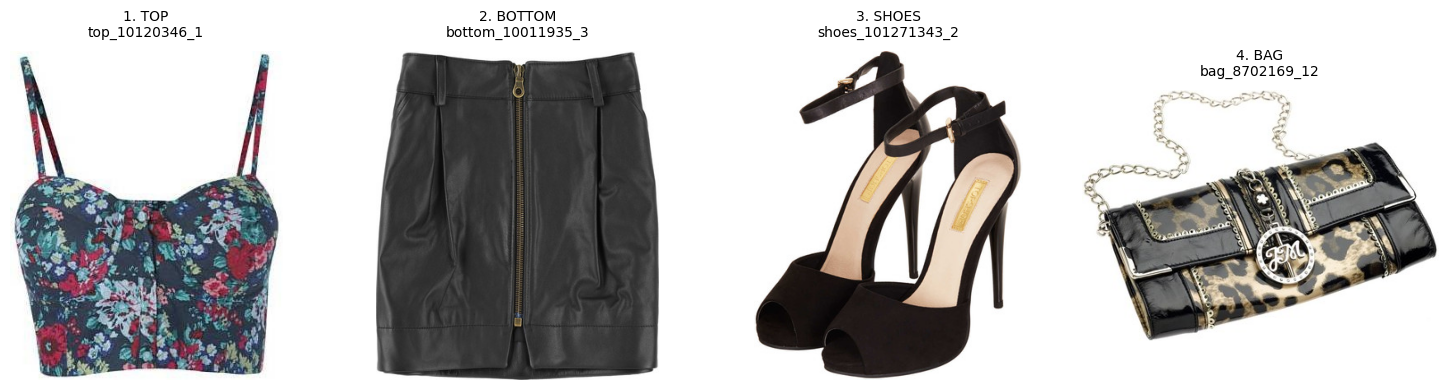


POLYVORE OUTFIT GENERATOR MENU:
1. Generate outfit from dataset item
2. Generate random outfit
3. Exit


Enter your choice (1-4):  2


Starting with random seed: bag_13440271_4
Seed category: bag
GENERATED OUTFIT
VSE Visual Coherence Score: 0.683
------------------------------------------------------------


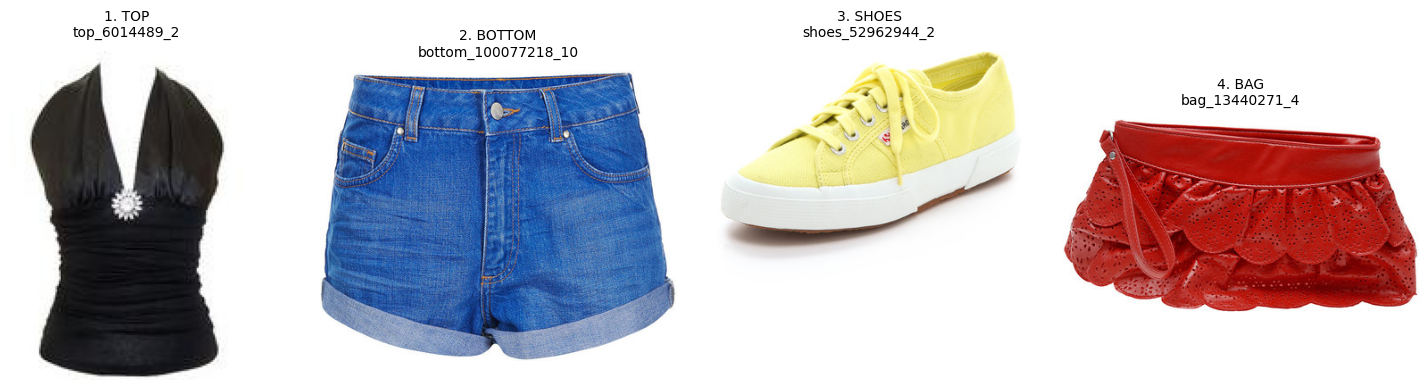


POLYVORE OUTFIT GENERATOR MENU:
1. Generate outfit from dataset item
2. Generate random outfit
3. Exit


Enter your choice (1-4):  2


Starting with random seed: top_10120346_1
Seed category: top
GENERATED OUTFIT
VSE Visual Coherence Score: 0.703
------------------------------------------------------------


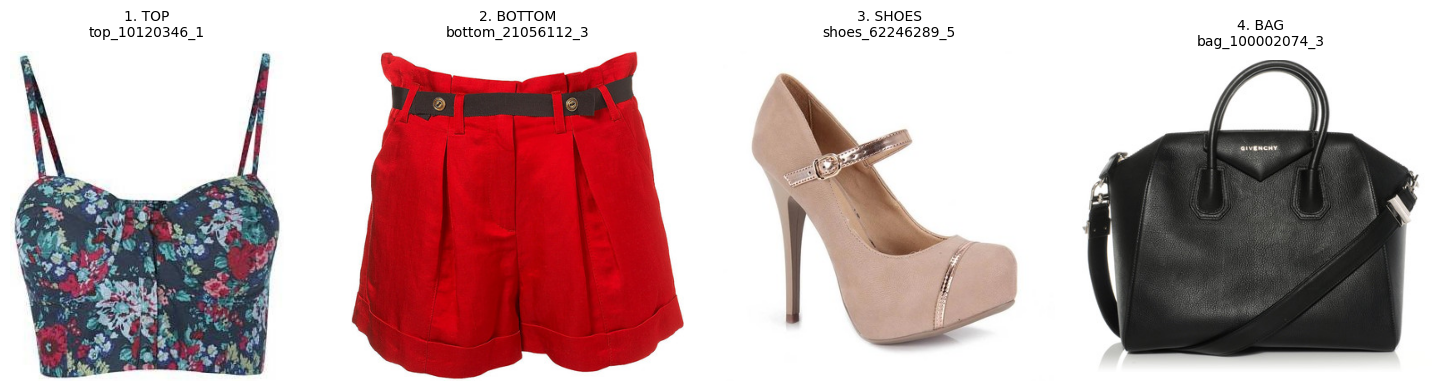


POLYVORE OUTFIT GENERATOR MENU:
1. Generate outfit from dataset item
2. Generate random outfit
3. Exit


Enter your choice (1-4):  3


Goodbye!


In [3]:
import os
import json
import numpy as np
import tensorflow as tf
import pickle as pkl
from PIL import Image
import io
import random
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, HTML
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# TensorFlow version compatibility
if tf.__version__.startswith('1.'):
    tf.logging.set_verbosity(tf.logging.ERROR)
else:
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    tf.compat.v1.disable_eager_execution()
    tf.compat.v1.disable_v2_behavior()

class ModelConfig(object):
    def __init__(self):
        self.image_height = 299
        self.image_width = 299
        self.image_format = "jpeg"
        self.embedding_size = 512
        self.num_lstm_units = 512
        self.initializer_scale = 0.08
        self.rnn_type = "lstm"

def load_features(features_path):
    """Load existing features (features must be pre-extracted)."""
    
    if os.path.exists(features_path):
        print(f"Loading existing features from {features_path}")
        with open(features_path, 'rb') as f:
            features = pkl.load(f)
        print(f"Loaded {len(features)} pre-computed features")
        return features
    
    raise FileNotFoundError(f"Features file not found: {features_path}")

def build_inference_model():
    """Build EXACT model architecture matching the checkpoint."""
    
    if tf.__version__.startswith('2.'):
        tf.compat.v1.reset_default_graph()
    else:
        tf.reset_default_graph()
    
    config = ModelConfig()
    initializer = tf.random_uniform_initializer(
        minval=-config.initializer_scale,
        maxval=config.initializer_scale)

    if tf.__version__.startswith('2.'):
        with tf.compat.v1.variable_scope("lstm"):
            # Forward LSTM - EXACT structure
            f_state_feed = tf.compat.v1.placeholder(dtype=tf.float32,
                                        shape=[None, 2 * config.num_lstm_units],  # 1024
                                        name="f_state_feed")
            f_input_feed = tf.compat.v1.placeholder(dtype=tf.float32,
                                        shape=[None, config.embedding_size],  # 512
                                        name="f_input_feed")
            
            # Backward LSTM - EXACT structure
            b_state_feed = tf.compat.v1.placeholder(dtype=tf.float32,
                                        shape=[None, 2 * config.num_lstm_units],  # 1024
                                        name="b_state_feed")
            b_input_feed = tf.compat.v1.placeholder(dtype=tf.float32,
                                        shape=[None, config.embedding_size],  # 512
                                        name="b_input_feed")
            
            # Create LSTM cells exactly as in original
            with tf.compat.v1.variable_scope("FW"):
                with tf.compat.v1.variable_scope("BasicLSTMCell"):
                    with tf.compat.v1.variable_scope("Linear"):
                        fw_W = tf.compat.v1.get_variable("Matrix", 
                                                        shape=[1024, 2048],
                                                        initializer=initializer)
                        fw_b = tf.compat.v1.get_variable("Bias", 
                                                        shape=[2048],
                                                        initializer=tf.zeros_initializer())
                
                # Manual LSTM computation for forward
                combined_input = tf.concat([f_input_feed, tf.split(f_state_feed, 2, axis=1)[0]], axis=1)
                linear_output = tf.matmul(combined_input, fw_W) + fw_b
                
                # Split into gates (i, j, f, o)
                i, j, f, o = tf.split(linear_output, 4, axis=1)
                
                # LSTM gates
                i = tf.sigmoid(i)
                f = tf.sigmoid(f + 1.0)  # forget bias
                o = tf.sigmoid(o)
                j = tf.tanh(j)
                
                # Previous state
                c_prev, h_prev = tf.split(f_state_feed, 2, axis=1)
                
                # New state
                c = f * c_prev + i * j
                h = o * tf.tanh(c)
                
                # Create outputs with the exact names needed for inference
                f_lstm_state_output = tf.concat([c, h], axis=1)
                f_lstm_outputs = h
                
                # Create named tensors for inference
                tf.identity(f_lstm_state_output, name="f_state")
                tf.identity(f_lstm_outputs, name="f_output")
            
            with tf.compat.v1.variable_scope("BW"):
                with tf.compat.v1.variable_scope("BasicLSTMCell"):
                    with tf.compat.v1.variable_scope("Linear"):
                        bw_W = tf.compat.v1.get_variable("Matrix", 
                                                        shape=[1024, 2048],
                                                        initializer=initializer)
                        bw_b = tf.compat.v1.get_variable("Bias", 
                                                        shape=[2048],
                                                        initializer=tf.zeros_initializer())
                
                # Manual LSTM computation for backward
                combined_input = tf.concat([b_input_feed, tf.split(b_state_feed, 2, axis=1)[0]], axis=1)
                linear_output = tf.matmul(combined_input, bw_W) + bw_b
                
                # Split into gates
                i, j, f, o = tf.split(linear_output, 4, axis=1)
                
                # LSTM gates
                i = tf.sigmoid(i)
                f = tf.sigmoid(f + 1.0)
                o = tf.sigmoid(o)
                j = tf.tanh(j)
                
                # Previous state
                c_prev, h_prev = tf.split(b_state_feed, 2, axis=1)
                
                # New state
                c = f * c_prev + i * j
                h = o * tf.tanh(c)
                
                # Create outputs with the exact names needed for inference
                b_lstm_state_output = tf.concat([c, h], axis=1)
                b_lstm_outputs = h
                
                # Create named tensors for inference
                tf.identity(b_lstm_state_output, name="b_state")
                tf.identity(b_lstm_outputs, name="b_output")
        
        # Output projections - EXACT from checkpoint
        with tf.compat.v1.variable_scope("f_logits"):
            f_W = tf.compat.v1.get_variable("weights", shape=[512, 512], initializer=initializer)
            f_b = tf.compat.v1.get_variable("biases", shape=[512], initializer=tf.zeros_initializer())
            f_logits_output = tf.matmul(f_lstm_outputs, f_W) + f_b
            tf.identity(f_logits_output, name="f_logits")
        
        with tf.compat.v1.variable_scope("b_logits"):
            b_W = tf.compat.v1.get_variable("weights", shape=[512, 512], initializer=initializer)
            b_b = tf.compat.v1.get_variable("biases", shape=[512], initializer=tf.zeros_initializer())
            b_logits_output = tf.matmul(b_lstm_outputs, b_W) + b_b
            tf.identity(b_logits_output, name="b_logits")
        
        # VSE Embedding Layer - EXACT from checkpoint
        with tf.compat.v1.variable_scope("image_embedding"):
            vse_W = tf.compat.v1.get_variable("weights", shape=[2048, 512], initializer=initializer)
            inception_features = tf.compat.v1.placeholder(dtype=tf.float32, 
                                                         shape=[None, 2048], 
                                                         name="inception_features")
            vse_output = tf.matmul(inception_features, vse_W)
            tf.identity(vse_output, name="vse_features")
    
    return config

def rnn_one_step(sess, input_feed, lstm_state, direction='f'):
    """Run one step of the RNN with EXACT checkpoint structure."""
    if direction == 'f':
        try:
            [lstm_state, lstm_output] = sess.run(
                fetches=['lstm/FW/f_state:0', 'f_logits/f_logits:0'],
                feed_dict={'lstm/f_input_feed:0': input_feed,
                           'lstm/f_state_feed:0': lstm_state})
        except Exception as e:
            try:
                [lstm_state, lstm_output] = sess.run(
                    fetches=['lstm/f_state:0', 'f_logits/f_logits:0'],
                    feed_dict={'lstm/f_input_feed:0': input_feed,
                               'lstm/f_state_feed:0': lstm_state})
            except Exception as e2:
                raise e
    else:
        try:
            [lstm_state, lstm_output] = sess.run(
                fetches=['lstm/BW/b_state:0', 'b_logits/b_logits:0'],
                feed_dict={'lstm/b_input_feed:0': input_feed,
                           'lstm/b_state_feed:0': lstm_state})
        except Exception as e:
            try:
                [lstm_state, lstm_output] = sess.run(
                    fetches=['lstm/b_state:0', 'b_logits/b_logits:0'],
                    feed_dict={'lstm/b_input_feed:0': input_feed,
                               'lstm/b_state_feed:0': lstm_state})
            except Exception as e2:
                raise e
    
    return lstm_state, lstm_output

def generate_outfit_with_vse(sess, seed_features, candidate_features, candidate_ids, 
                            num_lstm_units, use_vse=True, vse_weight=0.5,
                            max_forward=4, max_backward=3):
    """Generate complete outfit from seed using LSTM + VSE hybrid approach."""
    
    # Prepare candidate feature matrices
    rnn_feature_matrix = np.array([candidate_features[item_id]['image_rnn_feat'] 
                                  for item_id in candidate_ids])
    
    if use_vse:
        vse_feature_matrix = np.array([candidate_features[item_id]['image_feat'] 
                                      for item_id in candidate_ids])
        seed_vse = None
        # Find seed VSE features by matching RNN features
        for item_id, features in candidate_features.items():
            if np.array_equal(features['image_rnn_feat'], seed_features):
                seed_vse = features['image_feat']
                break
        
        if seed_vse is None:
            seed_vse = np.zeros(512)
    
    # Forward generation
    forward_items = []
    lstm_state = np.zeros([1, 2 * num_lstm_units])  # [1, 1024]
    
    input_feed = np.reshape(seed_features, [1, -1])
    [lstm_state, lstm_output] = rnn_one_step(sess, input_feed, lstm_state, 'f')
    
    for step in range(max_forward):
        # Calculate LSTM scores
        lstm_scores = np.exp(np.dot(lstm_output, rnn_feature_matrix.T))
        lstm_scores = lstm_scores / np.sum(lstm_scores)
        
        if use_vse and seed_vse is not None:
            # Calculate VSE compatibility scores
            vse_similarities = cosine_similarity([seed_vse], vse_feature_matrix)[0]
            vse_scores = (vse_similarities + 1) / 2  # Convert to 0-1 scale
            vse_scores = vse_scores / np.sum(vse_scores)  # Normalize
            
            # Hybrid scoring
            final_scores = (1 - vse_weight) * lstm_scores[0] + vse_weight * vse_scores
        else:
            final_scores = lstm_scores[0]
        
        # Get top candidates (exclude END token for now)
        top_idx = np.argsort(-final_scores)[:-1][:5]  # Top 5 excluding END
        next_item_idx = top_idx[0]
        
        # Check for end condition
        if final_scores[-1] > 0.01:  # END token probability
            break
        
        forward_items.append(candidate_ids[next_item_idx])
        
        # Continue with selected item
        input_feed = np.reshape(rnn_feature_matrix[next_item_idx], [1, -1])
        [lstm_state, lstm_output] = rnn_one_step(sess, input_feed, lstm_state, 'f')
    
    # Backward generation
    backward_items = []
    lstm_state = np.zeros([1, 2 * num_lstm_units])  # [1, 1024]
    
    input_feed = np.reshape(seed_features, [1, -1])
    [lstm_state, lstm_output] = rnn_one_step(sess, input_feed, lstm_state, 'b')
    
    for step in range(max_backward):
        # Calculate LSTM scores
        lstm_scores = np.exp(np.dot(lstm_output, rnn_feature_matrix.T))
        lstm_scores = lstm_scores / np.sum(lstm_scores)
        
        if use_vse and seed_vse is not None:
            # Calculate VSE compatibility scores
            vse_similarities = cosine_similarity([seed_vse], vse_feature_matrix)[0]
            vse_scores = (vse_similarities + 1) / 2  # Convert to 0-1 scale
            vse_scores = vse_scores / np.sum(vse_scores)  # Normalize
            
            # Hybrid scoring
            final_scores = (1 - vse_weight) * lstm_scores[0] + vse_weight * vse_scores
        else:
            final_scores = lstm_scores[0]
        
        top_idx = np.argsort(-final_scores)[:-1][:5]
        next_item_idx = top_idx[0]
        
        if final_scores[-1] > 0.01:
            break
        
        backward_items.append(candidate_ids[next_item_idx])
        
        input_feed = np.reshape(rnn_feature_matrix[next_item_idx], [1, -1])
        [lstm_state, lstm_output] = rnn_one_step(sess, input_feed, lstm_state, 'b')
    
    return backward_items[::-1], forward_items

def enforce_outfit_rules(seed_id, backward_items, forward_items, candidate_features):
    
    # Get seed category
    seed_category = candidate_features[seed_id].get('category', 'unknown')
    
    # Combine all items
    all_items = backward_items + [seed_id] + forward_items
    
    # Categorize items
    outfit_by_category = {
        'dress': [],
        'top': [],
        'bottom': [],
        'shoes': [],
        'bag': []
    }
    
    for item_id in all_items:
        category = candidate_features[item_id].get('category', 'unknown')
        if category in outfit_by_category:
            outfit_by_category[category].append(item_id)
    
    balanced_outfit = []
    
    # Determine outfit type based on seed category
    if seed_category == 'dress':
        outfit_type = 'dress'
    elif seed_category in ['top', 'bottom']:
        outfit_type = 'top_bottom'
    else:
        # For shoes, bags, or unknown seeds, decide based on availability
        has_dress = len(outfit_by_category['dress']) > 0
        has_top = len(outfit_by_category['top']) > 0
        has_bottom = len(outfit_by_category['bottom']) > 0
        
        if has_dress and (not has_top or not has_bottom):
            outfit_type = 'dress'
        elif has_top and has_bottom:
            outfit_type = 'top_bottom'
        elif has_dress:
            outfit_type = 'dress'
        else:
            outfit_type = 'top_bottom'
    
    # Build outfit based on determined type
    if outfit_type == 'dress':
        # Add dress
        if seed_category == 'dress':
            balanced_outfit.append(seed_id)
        elif outfit_by_category['dress']:
            balanced_outfit.append(outfit_by_category['dress'][0])
        
        # Add shoes
        if seed_category == 'shoes':
            balanced_outfit.append(seed_id)
        elif outfit_by_category['shoes']:
            balanced_outfit.append(outfit_by_category['shoes'][0])
        else:
            shoes = find_matching_item(candidate_features, 'shoes', balanced_outfit)
            if shoes:
                balanced_outfit.append(shoes)
        
        # Add bag
        if seed_category == 'bag':
            balanced_outfit.append(seed_id)
        elif outfit_by_category['bag']:
            balanced_outfit.append(outfit_by_category['bag'][0])
        else:
            bag = find_matching_item(candidate_features, 'bag', balanced_outfit)
            if bag:
                balanced_outfit.append(bag)
    
    else:  # top_bottom outfit
        # Add top
        if seed_category == 'top':
            balanced_outfit.append(seed_id)
        elif outfit_by_category['top']:
            balanced_outfit.append(outfit_by_category['top'][0])
        else:
            top = find_matching_item(candidate_features, 'top', balanced_outfit)
            if top:
                balanced_outfit.append(top)
        
        # Add bottom
        if seed_category == 'bottom':
            balanced_outfit.append(seed_id)
        elif outfit_by_category['bottom']:
            balanced_outfit.append(outfit_by_category['bottom'][0])
        else:
            bottom = find_matching_item(candidate_features, 'bottom', balanced_outfit)
            if bottom:
                balanced_outfit.append(bottom)
        
        # Add shoes
        if seed_category == 'shoes':
            balanced_outfit.append(seed_id)
        elif outfit_by_category['shoes']:
            balanced_outfit.append(outfit_by_category['shoes'][0])
        else:
            shoes = find_matching_item(candidate_features, 'shoes', balanced_outfit)
            if shoes:
                balanced_outfit.append(shoes)
        
        # Add bag
        if seed_category == 'bag':
            balanced_outfit.append(seed_id)
        elif outfit_by_category['bag']:
            balanced_outfit.append(outfit_by_category['bag'][0])
        else:
            bag = find_matching_item(candidate_features, 'bag', balanced_outfit)
            if bag:
                balanced_outfit.append(bag)
    
    return balanced_outfit

def find_matching_item(candidate_features, target_category, current_outfit):
    available_items = []
    
    for item_id, features in candidate_features.items():
        if (features.get('category') == target_category and 
            item_id not in current_outfit and 
            item_id != 'END_TOKEN'):
            available_items.append(item_id)
    
    if available_items:
        return random.choice(available_items)
    
    return None

def calculate_vse_coherence(outfit_items, candidate_features):
    """Calculate VSE coherence score for the outfit."""
    vse_features = []
    valid_items = []
    
    for item_id in outfit_items:
        if item_id in candidate_features and 'image_feat' in candidate_features[item_id]:
            vse_feat = candidate_features[item_id]['image_feat']
            
            if isinstance(vse_feat, np.ndarray) and vse_feat.size > 0:
                norm = np.linalg.norm(vse_feat)
                if norm > 1e-6:
                    vse_feat_norm = vse_feat / norm
                    vse_features.append(vse_feat_norm)
                    valid_items.append(item_id)
    
    if len(vse_features) < 2:
        return 0.0
    
    vse_features = np.array(vse_features)
    
    # Calculate pairwise cosine similarities
    similarities = cosine_similarity(vse_features)
    
    # Get upper triangle (excluding diagonal)
    n = len(vse_features)
    upper_triangle = similarities[np.triu_indices(n, k=1)]
    
    # VSE coherence is the mean pairwise similarity
    coherence_score = np.mean(upper_triangle)
    
    # Convert to 0-1 scale (cosine similarity is -1 to 1)
    coherence_score = (coherence_score + 1) / 2
    
    return coherence_score

def display_outfit_with_images(outfit_items, candidate_features):
    """Display the outfit with actual images in a nice grid layout."""
    print("="*60)
    print("GENERATED OUTFIT")
    print("="*60)
    
    if not outfit_items:
        print("No items in outfit")
        return
    
    vse_score = calculate_vse_coherence(outfit_items, candidate_features)
    print(f"VSE Visual Coherence Score: {vse_score:.3f}")
    print("-" * 60)
    
    # Create figure for image display
    n_items = len(outfit_items)
    cols = min(4, n_items)
    rows = (n_items + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    # Track outfit composition
    outfit_composition = {}
    
    for i, item_id in enumerate(outfit_items):
        if i >= len(axes):
            break
            
        item_data = candidate_features.get(item_id, {})
        category = item_data.get('category', 'unknown')
        image_path = item_data.get('path', '')
        
        # Count categories
        outfit_composition[category] = outfit_composition.get(category, 0) + 1
        
        # Load and display image
        ax = axes[i]
        
        try:
            if os.path.exists(image_path):
                img = mpimg.imread(image_path)
                ax.imshow(img)
                ax.set_title(f"{i+1}. {category.upper()}\n{item_id}", 
                           fontsize=10, pad=10)
            else:
                ax.text(0.5, 0.5, f"Image\nNot Found\n\n{category.upper()}\n{item_id}", 
                       ha='center', va='center', fontsize=8,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error Loading\nImage\n\n{category.upper()}\n{item_id}", 
                   ha='center', va='center', fontsize=8,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
        
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(len(outfit_items), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("="*60)

def generate_random_outfit(sess, candidate_features, candidate_ids, num_lstm_units):
    """Generate outfit starting from random seed using LSTM + VSE Hybrid."""
    
    # Select random seed (exclude END token)
    valid_items = [item_id for item_id in candidate_ids if item_id != 'END_TOKEN']
    seed_id = random.choice(valid_items)
    seed_features = candidate_features[seed_id]['image_rnn_feat']
    
    print(f"Starting with random seed: {seed_id}")
    print(f"Seed category: {candidate_features[seed_id].get('category', 'unknown')}")
    
    # Generate outfit using fixed LSTM + VSE Hybrid approach
    backward_items, forward_items = generate_outfit_with_vse(
        sess, seed_features, candidate_features, candidate_ids, num_lstm_units,
        use_vse=True, vse_weight=0.5
    )
    
    return seed_id, backward_items, forward_items

def interactive_menu(model_checkpoint, dataset_path, features_path):
    """Main interactive menu system - streamlined 4-option version."""
    
    # Load features
    print("Loading dataset features...")
    candidate_features = load_features(features_path)
    candidate_ids = list(candidate_features.keys())
    
    print(f"Loaded {len(candidate_ids)} items from dataset")
    
    # Categories summary
    categories = {}
    for item_id, data in candidate_features.items():
        cat = data['category']
        categories[cat] = categories.get(cat, 0) + 1
    
    print("\nDataset categories:")
    for cat, count in categories.items():
        print(f"  {cat}: {count} items")
    
    # Build model architecture
    config = build_inference_model()
    
    # Create session and restore checkpoint
    if tf.__version__.startswith('2.'):
        sess = tf.compat.v1.Session()
        saver = tf.compat.v1.train.Saver()
    else:
        sess = tf.Session()
        saver = tf.train.Saver()
    
    try:
        print(f"\nLoading checkpoint: {model_checkpoint}")
        saver.restore(sess, model_checkpoint)
        
        while True:
            print("\n" + "="*60)
            print("POLYVORE OUTFIT GENERATOR MENU:")
            print("1. Generate outfit from dataset item")
            print("2. Generate random outfit")
            print("3. Exit")
            print("="*60)
            
            try:
                choice = input("Enter your choice (1-4): ").strip()
                
                if choice == '1':
                    print("\nAvailable items in your dataset:")
                    valid_items = [item_id for item_id in candidate_ids if item_id != 'END_TOKEN']
                    
                    by_category = {}
                    for item_id in valid_items:
                        cat = candidate_features[item_id].get('category', 'unknown')
                        if cat not in by_category:
                            by_category[cat] = []
                        by_category[cat].append(item_id)
                    
                    for cat, items in by_category.items():
                        print(f"\n{cat.upper()}:")
                        for i, item in enumerate(items[:5]):
                            print(f"   {item}")
                        if len(items) > 5:
                            print(f"   ... and {len(items)-5} more")
                    
                    seed_choice = input("\nEnter item name (or 'random'): ").strip()
                    
                    if seed_choice.lower() == 'random':
                        seed_id = random.choice(valid_items)
                    elif seed_choice in candidate_features:
                        seed_id = seed_choice
                    else:
                        seed_id = random.choice(valid_items)
                    
                    try:
                        seed_features = candidate_features[seed_id]['image_rnn_feat']
                        print(f"Using seed: {seed_id}")
                        print(f"Seed category: {candidate_features[seed_id].get('category', 'unknown')}")
                        
                        # Generate outfit using fixed VSE hybrid approach
                        backward_items, forward_items = generate_outfit_with_vse(
                            sess, seed_features, candidate_features, candidate_ids, 
                            config.num_lstm_units, use_vse=True, vse_weight=0.5
                        )
                        
                        # Apply outfit balancing rules
                        balanced_outfit = enforce_outfit_rules(
                            seed_id, backward_items, forward_items, candidate_features
                        )
                        
                        # Display with images and VSE evaluation
                        display_outfit_with_images(balanced_outfit, candidate_features)
                        
                    except Exception as e:
                        print(f"Error generating outfit: {e}")
                        import traceback
                        traceback.print_exc()
                
                elif choice == '2':
                    # Generate random outfit
                    try:
                        seed_id, backward_items, forward_items = generate_random_outfit(
                            sess, candidate_features, candidate_ids, config.num_lstm_units
                        )
                        
                        # Apply outfit balancing rules
                        balanced_outfit = enforce_outfit_rules(
                            seed_id, backward_items, forward_items, candidate_features
                        )
                        
                        # Display with images and VSE evaluation
                        display_outfit_with_images(balanced_outfit, candidate_features)
                        
                    except Exception as e:
                        print(f"Error generating outfit: {e}")
                        import traceback
                        traceback.print_exc()
                
                
                elif choice == '3':
                    print("Goodbye!")
                    break
                
                else:
                    print("Invalid choice! Please enter 1-4.")
                
            except KeyboardInterrupt:
                print("\nGoodbye!")
                break
            except Exception as e:
                print(f"Error: {e}")
                import traceback
                traceback.print_exc()
    
    finally:
        sess.close()

def main():
    
    # UPDATE THESE PATHS FOR YOUR SETUP
    MODEL_CHECKPOINT = "/kaggle/input/final-inference-model/model.ckpt-34865"
    DATASET_PATH = "/kaggle/input/sample-dataset-for-inference/My Dataset"
    FEATURES_PATH = "/kaggle/working/dataset_features.pkl"
    
    if not os.path.exists(FEATURES_PATH):
        print(f"Features file not found: {FEATURES_PATH}")
        print("Run the feature extraction steps first!")
        print("   1. Run Step 1: InceptionV3 feature extraction")
        print("   2. Run Step 2: VSE transformation")
        return
    
    interactive_menu(MODEL_CHECKPOINT, DATASET_PATH, FEATURES_PATH)

if __name__ == "__main__":
    main()